In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import glob
import seaborn as sns

In [43]:
group = "cfc11" #'halocarbons'
fns = glob.glob(f"/user/home/lw13938/work/ciceroscm/RF_sensitivity/ensemble/outputs/ensemble_{group}*.nc")
ds_list = []
for fn in fns:
    ds_list = ds_list + [xr.open_dataset(fn)]
ds = xr.concat(ds_list, dim="ensemble")

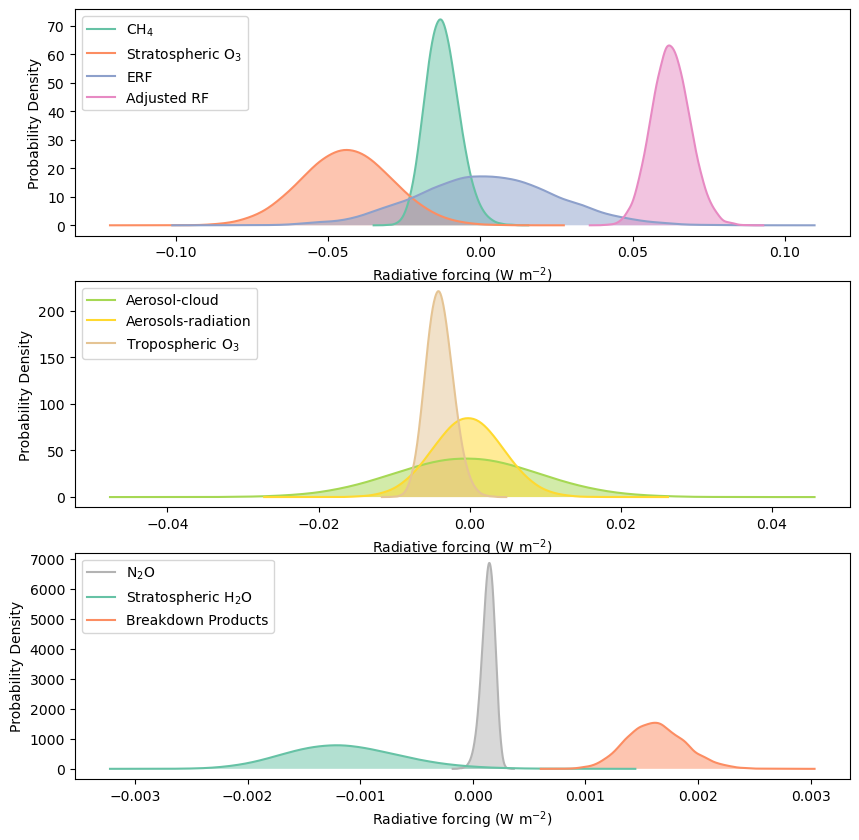

In [46]:
groups = [["CH4","STRAT_O3", "Total_forcing", "direct_forcing"],["SO4_IND", "aerosols","TROP_O3",], ["N2O", "STRAT_H2O","breakdown_products"]]
labels = ["CH$_4$", "Stratospheric O$_3$", "ERF", "Adjusted RF", "Aerosol-cloud", "Aerosols-radiation", "Tropospheric O$_3$", "N$_2$O", "Stratospheric H$_2$O", "Breakdown Products"]
colours = sns.color_palette("Set2", 10)
ind = ds.year.values == 2019
# limits = [[-0.45,0.45],[-0.1,0.1],[-0.01, 0.01]]
limits = [[None,None],[None,None],[None, None]]
i = 0
fig, axes = plt.subplots(3, 1, figsize=(10,10))
for ax, group_vars,limit in zip(axes,groups, limits):
   # plt.figure(figsize=(10,4))
   for var in group_vars:
      if var == "aerosols":
         forcing_arr = ds["OC"][:,ind,:].values.ravel() + ds["SO4_DIR"][:,ind,:].values.ravel()
      else:
         forcing_arr = ds[var][:,ind,:].values.ravel()
         if np.all(np.isclose(forcing_arr,forcing_arr[0], atol=1e-6)):
            continue
         addabit = abs(forcing_arr.max() - forcing_arr.min())*0.1
      kde_x = np.linspace(forcing_arr.min()-addabit , forcing_arr.max()+addabit, 300)
      kernel = stats.gaussian_kde(forcing_arr)
      rfkde = kernel(kde_x)
      imode = rfkde.argmax()
      col = colours[i]
      ax.plot(kde_x, rfkde, color=col, label=labels[i]) #label=var, 
      # Fill under the curve
      ax.fill_between(kde_x, 0, rfkde, alpha=0.5, facecolor=col)
      ax.set_xlabel("Radiative forcing (W m$^{-2}$)")
      ax.set_ylabel("Probability Density")
      # ax.set_xlim(limit)
      ax.legend(loc="upper left")
      i = i + 1
      


Text(0.5, 0, 'Year')

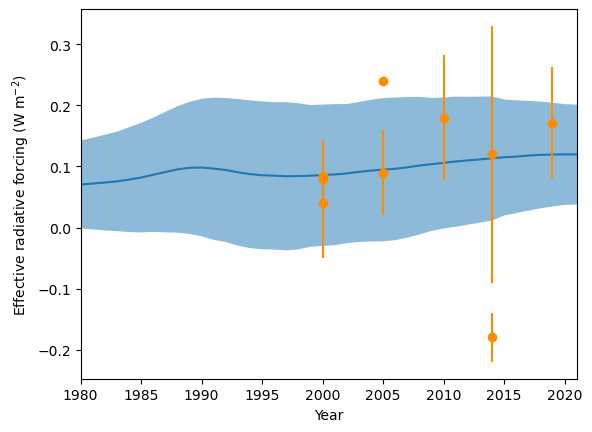

In [29]:
erf_dict = {
    "oconnor" : [2014, -0.18,  0.04],
    "morgenstern" : [2000, 0.04, 0.09],
    "chiodo" : [2005, 0.24, 0],
    "thornhill": [2014, 0.12, 0.21],
    "ar6" : [2019, 0.171, 0.0918],
    "ar5" : [2010, 0.18, 0.103],
    "mogenstern2" : [2000,0.085, 0.059],
    "sodve" : [2000, 0.08, 0],    
    "shindell" : [2005,0.09,0.07],
    
}


data = ds["Total_forcing"]
flattened_data = data.stack(points=("ensemble", "sample")).values
plt.plot(ds.year.values, np.mean(flattened_data,1))
lower = np.percentile(flattened_data, 16, axis=1)
upper = np.percentile(flattened_data, 84, axis=1)
plt.fill_between(ds.year.values, lower, upper, alpha=0.5)
for key in erf_dict.keys():
    plt.errorbar(erf_dict[key][0], erf_dict[key][1], yerr=erf_dict[key][2], fmt='o', label=key, color="darkorange")

plt.xlim(1980, 2021)
plt.ylabel("Effective radiative forcing (W m$^{-2}$)")
plt.xlabel("Year")

([], [])

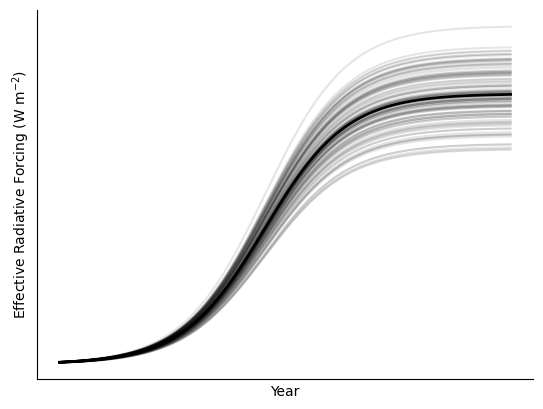

In [37]:
# x = np.linspace(-5, 6, 1000)
def sigmoid(z):
    return 1/(1 + np.exp(-z))
# plt.plot(x, sigmoid(x))
# plt.plot(x, sigmoid(x)*0.7)
# # Get rid of tick labels
# plt.xticks([])
# plt.yticks([])
# # Remove top and right axes
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.xlabel("Year")
# plt.ylabel("Effective Radiative Forcing (W m$^{-2}$)")

# An example plot showing an ensesmble of simulations, where there is a thin line for each ensemble member, and a thick line for the ensemble mean
nmem = 100
x = np.linspace(-5, 6, 1000)
y = np.expand_dims(sigmoid(x),1) @ np.expand_dims(np.random.normal(loc=1, scale=0.1,size=nmem),0)
for i in range(nmem):
    plt.plot(x, y[:,i] - y[:,i]*0.7, color="black", alpha=0.1)
plt.plot(x, (y- y*0.7).mean(axis=1), color="black", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Effective Radiative Forcing (W m$^{-2}$)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])

Text(0, 0.5, 'Change in CH$_4$ lifetime (%)')

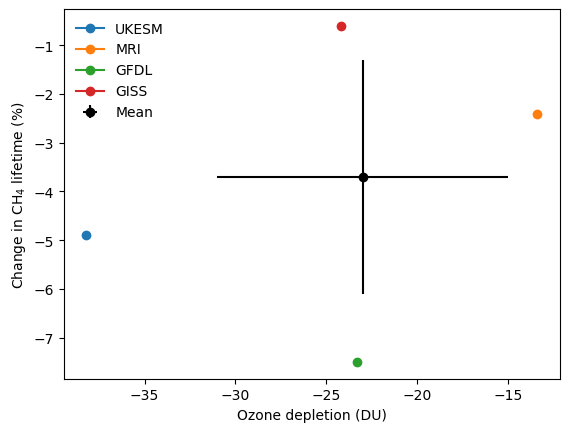

In [60]:
DU = {"CNRM":-23.4,
      "UKESM":-38.2,
      "MRI":-13.4,
      "GFDL":-23.3,
      "GISS":-24.2,
      "CESM":-22.7,
       }
ch4 = {"UKESM":-4.9,
       "GFDL":-7.5,
       'GISS':-0.6,
       "MRI":-2.4}

for key in DU.keys():
    if key in ch4.keys():
        plt.plot(DU[key], ch4[key], marker="o", label=key)
plt.errorbar(-23., -3.7, xerr=8, yerr=2.4, fmt="o", color="black", label="Mean")
plt.legend(loc="upper left", frameon=False)
plt.xlabel("Ozone depletion (DU)")
plt.ylabel("Change in CH$_4$ lifetime (%)")

In [58]:
# Mean of all entries in a dictionary
np.std(list(DU.values()))

7.261083482052341